In [25]:
import spacy
from spacy.tokens import DocBin, Doc

nlp = spacy.load("models/fr_spacy_custom_spancat_edda")
Doc.set_extension("metadata", default={}, force=True)

with open("edda_serialized_docs_240131.bin", "rb") as f:
    serialized_bytes = f.read()

doc_bin = DocBin().from_bytes(serialized_bytes)
docs = list(doc_bin.get_docs(nlp.vocab))
jsonl = []
for doc in docs: 
    jsonl.append(dict(doc._.metadata, **doc.to_json()))

In [8]:
type(doc)

spacy.tokens.doc.Doc

### Book & Encycl. Classes

In [11]:
import math
from collections import defaultdict

class Encyclopedy:
    def __init__(self):
        self.books = []
        #self.word_count = defaultdict(int)
        #self.total_word_count = 0

    def _add_book(self, book):
        if hasattr(book, 'word_count') : # and len(book.word_count) > 1 and sum(book.word_count.values()) == book.total_word_count:
            #initialize 
            if not hasattr(self, 'word_count') and not self.books:
                self.word_count = book.word_count
                self.total_word_count = book.total_word_count
                self.books.append(book)
                return None
            else :
                self.books.append(book)
                for word, count in book.word_count.items():
                    self.word_count[word] += count
                self.total_word_count += book.total_word_count
        else:
            book._update_counts()
            self._add_book(book)

    def _update_counts(self):
        self.word_count = defaultdict(int)
        self.total_word_count = 0
        for book in self.books:
            if not hasattr(book, 'word_count') :
                book._update_counts()
            for word, count in book.word_count.items():
                self.word_count[word] += count
            self.total_word_count += book.total_word_count

    def tf(self, word):
        if not isinstance(word, str):
            return 0
        if word not in self.word_count:
            return 0
        return self.word_count.get(word, 0) / self.total_word_count

    def idf(self, word):
        """
        idf(word) = log(N / (1 + n))
        with :
         N - number of books
         n - number of books containing the word
        """
        
        if not isinstance(word, str):
            return 0
        if word not in self.word_count:
            return 0
        return math.log(len(self.books) / (1 + len([book for book in self.books if word in book.word_count])))

    def tfidf(self, word):
        if word not in self.word_count:
            return 0
        return self.tf(word) * self.idf(word)

class Book:
    def __init__(self):
        self.articles = []

    def __repr__(self):
        return f"Book with {len(self.articles)} articles"
    
    def __iter__(self):
        return iter(self.articles)

    def _reach_article(self, volume = None, article  = None, headword=None):
        for art in self.articles:
            if headword:
                if art.headword.lower() == headword.lower():
                    return art
            elif art.volume == volume and art.article == article:
                return art
        return None
 
    def _add_paragraph(self, paragraph):
        if not isinstance(paragraph, spacy.tokens.doc.Doc) :
            raise ValueError("paragraph must be a spacy Doc object")
        
        related_article = self._reach_article(volume=paragraph._.metadata['volume'],
                                              article=paragraph._.metadata['article'])
        
        if related_article and related_article.headword == paragraph._.metadata['headword']:
            related_article._add_paragraph(paragraph)

        else :
            spacy_dict = dict(paragraph._.metadata, **paragraph.to_json())
            new_article = Article(volume = spacy_dict['volume'],
                                  article = spacy_dict['article'],
                                  headword = spacy_dict['headword'],
                                  paragraphs_list = [paragraph],
                                  authors = spacy_dict['authors'],
                                  text = spacy_dict['text'],
                                  tokens = spacy_dict['tokens'],
                                  spans = spacy_dict['spans'])
            self._add_article(new_article)


    def _add_article(self, article):
        if not isinstance(article, Article):
            raise ValueError("article must be an Article object")
        if self._reach_article(volume = article.volume, article = article.article):
            raise ValueError("article with same *volume & article*  already in the book")
        
        self.articles.append(article)

        # # does the article  already have word_count ?
        # if hasattr(article, 'word_count') :

        #     #is it the first article ? 
        #     if not hasattr(self, 'word_count') and not self.articles:
        #         self.word_count = article.word_count
        #         self.total_word_count = article.total_word_count
        #         self.articles.append(article)
        #         return None
            
        #     else :
        #         self.articles.append(article)
        #         for word, count in article.word_count.items():
        #             self.word_count[word] += count                
        #         self.total_word_count += article.total_word_count
        # else:
        #     #article._update_counts()
        #     self.articles.append(article)

    def _update_counts(self, tag_type = None, smooth = False, ):
        """
        Counts phrases/words in the book that have the  given tag_type tags.
        :param tag_type: tag_type to count
        :type tag_type: list of str
        :param smooth: keeps only phrases starting with a capital letter
        :type smooth: bool
        """
        self.word_count = defaultdict(int)
        self.total_word_count = 0
        for article in self.articles:
            article._update_counts(tag_type = tag_type, smooth = smooth)
            for word, count in article.word_count.items():
                self.word_count[word] += count
            self.total_word_count += article.total_word_count

        self.word_count = dict(sorted(self.word_count.items(),
                                      key=lambda item: item[1],
                                      reverse=True)
                                )

    def tf(self, word):
        if not isinstance(word, str) or word not in self.word_count:
            return 0
        return self.word_count.get(word, 0) / self.total_word_count
    
    def idf(self, word):
        """
        idf(word) = log(N / (1 + n))
        with :
         N - number of articles in the book
         n - number of articles containing the word
        """
        if not isinstance(word, str):
            return 0
        if word not in self.word_count:
            return 0
        return math.log(len(self.articles) / (1 + len([article for article in self.articles if word in article.word_count])))
    
    def tfidf(self, word):
        if word not in self.word_count:
            return 0
        return self.tf(word) * self.idf(word)

### Article class

In [98]:
import spacy
from spacy.tokens import DocBin, Doc

class Article:
    def __init__(self,
                 #work = None,
                 volume = None,
                 article = None,
                 headword = None,
                 paragraphs_list = None,
                 authors = None,
                 #domains = None,
                 text = None,
                 tokens = None,
                 spans = None):
        """
        paragraphs_list : having the spacydoc architecture :
                work
                volume
                article
                paragraph
                headword
                authors
                domains
                text
                tokens
                '-- id
                '-- start
                '-- end
                spans
                '-- sc
                '--  '-- start
                '--  '-- end
                '--  '-- label
                '--  '-- kb_id
        """
        #self.work = work
        self.volume = volume
        self.article = article
        self.headword = headword
        self.paragraphs_list = paragraphs_list
        self.authors = authors
        #self.domains = domains
        self.text = text
        self.tokens = tokens
        self.spans = spans

    def __repr__(self):
        return self.headword

    def _add_paragraph(self, paragraph):
        if not isinstance(paragraph, spacy.tokens.doc.Doc) :
            raise ValueError("paragraph must be a spacy Doc object")
        if (self.volume != paragraph._.metadata['volume']) or (self.article != paragraph._.metadata['article']) or (self.headword != paragraph._.metadata['headword']):
            # print(self.volume, paragraph._.metadata['volume'])
            # print(self.article, paragraph._.metadata['article'])
            # print(self.headword, paragraph._.metadata['headword'])
            raise ValueError("paragraph does not match the article")
        
        self.paragraphs_list.append(paragraph)

        spacy_dict = dict(paragraph._.metadata, **paragraph.to_json())
        #concatenate texts :
        self.text += ' ' + paragraph.text
        #add and shift tokens :
        for token in spacy_dict['tokens']:
            token['id'] += len(self.tokens)
            token['start'] += len(self.text)
            token['end'] += len(self.text)
            self.tokens.append(token)
        #add and shift spans :
        for span in spacy_dict['spans']['sc']:
            span['start'] += len(self.text)
            span['end'] += len(self.text)
            self.spans['sc'].append(span)
            
    def _update_counts(self, tag_type=None, smooth=False):
        """
        Counts words in the Article
        :param tag_type: types of tags to count (list like: list of tags like ['NC-Spatial', 'NP-Spatial', 'ENE-Spatial', 'Domain-mark'])
        :param smooth: keeps only phrases starting with a capital letter
        """
        if not self.tokens:
            print("No text to count")
            return

        self.word_count = defaultdict(int)
        self.total_word_count = 0

        for span in self.spans.get('sc', []):
            if not tag_type or span.get('label') in tag_type:
                phrase = self.text[span.get('start', 0):span.get('end', 0)]
                if smooth:
                    while phrase and not phrase[0].isupper():
                        phrase = phrase[1:] if len(phrase) > 1 else ''
                self.word_count[phrase] += 1
                self.total_word_count += 1

        #sort word_count
        self.word_count = dict(sorted(self.word_count.items(), key=lambda item: item[1], reverse=True))

    def _get_first(self, type):
        for span in self.spans.get('sc', []):
            if span.get('label') == type:
                return self.text[span.get('start', 0):span.get('end', 0)]
        return None    
                
    def _nice_print(self, paragraph = 0):
        options = {'colors': {'NP-Spatial': '#27AE60', 
                              'NC-Spatial': '#85C1E9',
                              'ENE-Spatial': '#196F3D', 
                              'Relation': '#F5B041'}}
        spacy.displacy.render(self.paragraphs_list[paragraph],
                              style='span', options=options, jupyter=True)

### Geographical articles keys

In [3]:
import pandas as pd
df = pd.read_excel('/home/antoine/Documents/GitHub/toponym-disambiguation/data/matheus.xlsx')

In [4]:
geo_keys = []
for _,row in df.iterrows():
    geo_keys.append((row['volume'],row['numero']))
print(len(geo_keys))

15545


### Tests

In [ ]:
encyclopedia = Encyclopedy()
book1 = Book()
article1 = Article("Article Head 1", "Author 1", "Text of article 1. article example")
article2 = Article("Article Head 2", "Author 2", "Text of article 2")
book1._add_article(article1)
book1._add_article(article2)
encyclopedia._add_book(book1)
print(encyclopedia.word_count)
print(book1.word_count)
print(article1.word_count)
print(book1.tf('article'))
print(encyclopedia.tfidf('article'))
print(book1.idf('article'))

### Constructing my book

In [28]:
book = Book()
for paragraph in docs:
    if (paragraph._.metadata['volume'], paragraph._.metadata['article']) in geo_keys:
        book._add_paragraph(paragraph)

print(len(book.articles))
import pickle
with open('geobook4.pkl', 'wb') as f:
    pickle.dump(book, f)

15510


In [29]:
# read pickled geobook3
import pickle
with open('geobook4.pkl', mode='rb') as file :
    book = pickle.load(file)
print(len(book.articles))

15510


In [32]:
word = 'France'

book._update_counts(tag_type = ['NP-Spatial'], smooth=True)
print(book.word_count[word])
book._update_counts(tag_type = ['NP-Spatial'], smooth=False)
print(book.word_count[word])

1898
1809


In [9]:
etoile = book._reach_article(headword='ALLEMAGNE')

In [20]:
etoile.spans

{'sc': [{'start': 2, 'end': 11, 'label': 'Head', 'kb_id': ''},
  {'start': 74, 'end': 80, 'label': 'NP-Spatial', 'kb_id': ''},
  {'start': 146, 'end': 154, 'label': 'NP-Spatial', 'kb_id': ''},
  {'start': 309, 'end': 317, 'label': 'NP-Spatial', 'kb_id': ''},
  {'start': 318, 'end': 321, 'label': 'Relation', 'kb_id': ''},
  {'start': 322, 'end': 327, 'label': 'NP-Spatial', 'kb_id': ''},
  {'start': 339, 'end': 343, 'label': 'NP-Spatial', 'kb_id': ''},
  {'start': 14, 'end': 19, 'label': 'Domain-mark', 'kb_id': ''},
  {'start': 21, 'end': 31, 'label': 'NC-Spatial', 'kb_id': ''},
  {'start': 51, 'end': 59, 'label': 'NP-Spatial', 'kb_id': ''},
  {'start': 101, 'end': 111, 'label': 'NP-Spatial', 'kb_id': ''},
  {'start': 114, 'end': 124, 'label': 'NP-Spatial', 'kb_id': ''},
  {'start': 139, 'end': 145, 'label': 'NC-Spatial', 'kb_id': ''},
  {'start': 157, 'end': 168, 'label': 'NP-Spatial', 'kb_id': ''},
  {'start': 202, 'end': 211, 'label': 'NP-Spatial', 'kb_id': ''},
  {'start': 214, 'end'

In [33]:
book.articles[1601]._nice_print(0)

# Sankey

In [137]:
book._update_counts(tag_type = ['NP-Spatial'], smooth=True)
book.word_count.pop('')
NP = book.word_count

book._update_counts(tag_type = ['NC-Spatial'], smooth=False)
book.word_count.pop('')
nc = book.word_count

book._update_counts(tag_type = ['ENE-Spatial'], smooth=False)
book.word_count.pop('')
ene = book.word_count

In [99]:
def _get_first(article, type):
        """returns the token being labeled as TYPE
        :param type: label"""
        for span in article.spans.get('sc', []):
            if span.get('label') == type:
                return article.text[span.get('start', 0):span.get('end', 0)]
        return None

In [218]:
n_nc = 95
n_np = 30

#matrix of coocurrences with list(NP.keys())[:n] as index and list(nc.keys())[:n] columns
matrix = pd.DataFrame(0, index=list(NP.keys())[:n_np], columns=list(nc.keys())[:n_nc])
for article in book.articles:
    firstnp = _get_first(article, 'NP-Spatial')
    firstnc = _get_first(article, 'NC-Spatial')
    #print(article.text, '\n', firstnp, firstnc)
    if firstnp in matrix.index and firstnc in matrix.columns:
         matrix.loc[firstnp, firstnc] += 1



CITY_PATTERN = ['ville', 'capitale', 'bourg', 'village', 'chef-lieu', 'port']

AREA_PATTERN = ['province', 'comté', 'duché', 'contrée', 'terre',
                'territoire', 'confins', 'canton', 'électorat',
                'cercle',
                'pays', 'royaume', 'empire', 'état', 'principauté']

FRESHWATER_PATTERN = ['fleuve', 'riviere','lac', ]

SEA_PATTERN = ['côte', 'golfe', 'cap', 'détroit','mer', 'embouchure', 'île', ]

TOPGRAPHY_PATTERN = ['montagne', 'mont', 'vallée', 'promontoire', 'plaine']

BUILDING_PATTERN = ['château', 'temple', 'pont', 'route']

RELGION_PATTERN = ['évêché', 'diocèse', 'diocese', 'palatinat', 'abbaye', 'église', 'cathédrale']

BORDER_PATTERN = ['frontière', 'frontiere']

print(matrix.columns)
matrix['~CITY'] = 0
for spelling in CITY_PATTERN:
    for column_name in matrix.columns:
        if spelling in column_name:
            #print(spelling, column_name)
            matrix['~CITY'] += matrix[column_name]
            matrix.drop(columns=column_name, inplace=True)

matrix['~AREA'] = 0
for spelling in AREA_PATTERN:
    for column_name in matrix.columns:
        if spelling in column_name:
            #print(spelling, column_name)
            matrix['~AREA'] += matrix[column_name]
            matrix.drop(columns=column_name, inplace=True)

matrix['~FRESHWATER'] = 0
for spelling in FRESHWATER_PATTERN:
    for column_name in matrix.columns:
        if spelling in column_name:
            #print(spelling, column_name)
            matrix['~FRESHWATER'] += matrix[column_name]
            matrix.drop(columns=column_name, inplace=True)

matrix['~SEA'] = 0
for spelling in SEA_PATTERN:
    for column_name in matrix.columns:
        if spelling in column_name:
            #print(spelling, column_name)
            matrix['~SEA'] += matrix[column_name]
            matrix.drop(columns=column_name, inplace=True)

matrix['~TOPOGRAPHY'] = 0
for spelling in TOPGRAPHY_PATTERN:
    for column_name in matrix.columns:
        if spelling in column_name:
            #print(spelling, column_name)
            matrix['~TOPOGRAPHY'] += matrix[column_name]
            matrix.drop(columns=column_name, inplace=True)
        
matrix['~BUILDING'] = 0
for spelling in BUILDING_PATTERN:
    for column_name in matrix.columns:
        if spelling in column_name:
            #print(spelling, column_name)
            matrix['~BUILDING'] += matrix[column_name]
            matrix.drop(columns=column_name, inplace=True)

matrix['~RELIGION'] = 0
for spelling in RELGION_PATTERN:
    for column_name in matrix.columns:
        if spelling in column_name:
            #print(spelling, column_name)
            matrix['~RELIGION'] += matrix[column_name]
            matrix.drop(columns=column_name, inplace=True)

matrix['~BORDER'] = 0
for spelling in BORDER_PATTERN:
    for column_name in matrix.columns:
        if spelling in column_name:
            #print(spelling, column_name)
            matrix['~BORDER'] += matrix[column_name]
            matrix.drop(columns=column_name, inplace=True)
    


Index(['ville', 'petite ville', 'la mer', 'la riviere', 'royaume',
       'la province', 'pays', 'l'île', 'riviere', 'la ville', 'capitale',
       'la côte', 'cette ville', 'comté', 'île', 'duché', 'fleuve',
       'la capitale', 'province', 'le pays', 'le golfe', 'bourg', 'villes',
       'l'embouchure', 'contrée', 'lac', 'golfe', 'montagnes', 'le comté',
       'mont', 'îles', 'montagne', 'le duché', 'Cette ville', 'ancienne ville',
       'l'empire', 'un château', 'le royaume', 'petite riviere', 'la route',
       'le lac', 'les terres', 'village', 'une montagne', 'la terre',
       'cette île', 'les confins', 'cercle', 'port', 'l'état',
       'un évêché suffragant', 'le cercle', 'diocèse', 'les montagnes',
       'le mont', 'le fleuve', 'les frontieres', 'une ville', 'cap',
       'cette province', 'petite île', 'l'évêché', 'la principauté',
       'petit pays', 'canton', 'ce fleuve', 'la vallée', 'cette montagne',
       'cette riviere', 'château', 'le cap', 'promontoire', 'pala

In [219]:
#sum of all coefficients in matrix
matrix.sum().sum()


6431

In [225]:
label = matrix.columns.tolist() + matrix.index.tolist()

link = dict(source=[], target=[], value=[])
for idx,row in matrix.iterrows():
    for col in row.index:
        link['source'].append(label.index(col))
        link['target'].append(label.index(idx))
        link['value'].append(row[col])

fig = go.Figure(data=[go.Sankey(node = dict(pad = 15,
                                            thickness = 20,
                                            line = dict(color = "black", width = 0.5),
                                            label = label),
                                            link = link)
                                            ],
                                            )


fig.update_layout(
    title_text="Co-occurences du 1er NC et 1er NP<br> À gauche, les NC sont regroupés dans des catégories<br>À droite, les 30 NP les plus fréquents seulement sont affichés",
    title_x=0.5,  # Center the title horizontally (0 to 1)
    title_y=0.97,  # Move the title up vertically (0 to 1)
    font_size=8,
    width=600,
    height=400,
    margin=dict(t=50)  # Increase the top margin to accommodate the title
)

#size
fig.update_layout(width=800, height=500)
fig.show()


In [226]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Add your existing code here (from label to fig.show())

# Generate the HTML string
html_string = pio.to_html(fig, full_html=False, include_plotlyjs='cdn')

# Write the HTML string to a file
with open("my_sankey_diagram.html", "w") as f:
    f.write(html_string)


# Term frenquencies

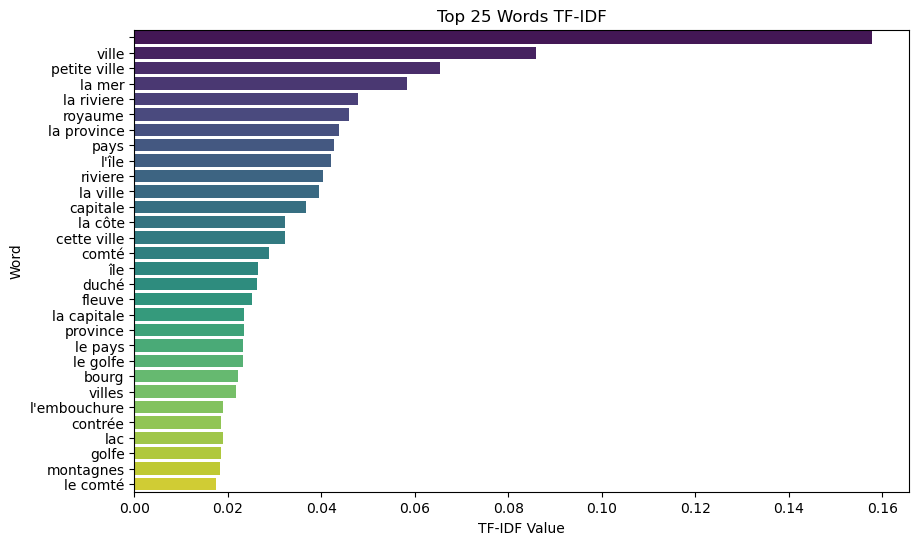

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
book._update_counts(tag_type = ['NC-Spatial'], smooth=False)
keys = sorted(book.word_count.items(), key=lambda x: x[1], reverse=True)[:30]
tfidf = [book.tfidf(key[0]) for key in keys]
data = {'Word': [key[0] for key in keys],
        'TF': [book.tf(key[0]) for key in keys],
        'IDF': [book.idf(key[0]) for key in keys],
        'TF-IDF': tfidf}

# Convert the dictionary into a DataFrame
df = pd.DataFrame(data)

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='TF-IDF', y='Word', data=df, palette='viridis')
plt.title('Top 25 Words TF-IDF')
plt.xlabel('TF-IDF Value')
plt.ylabel('Word')
plt.show()


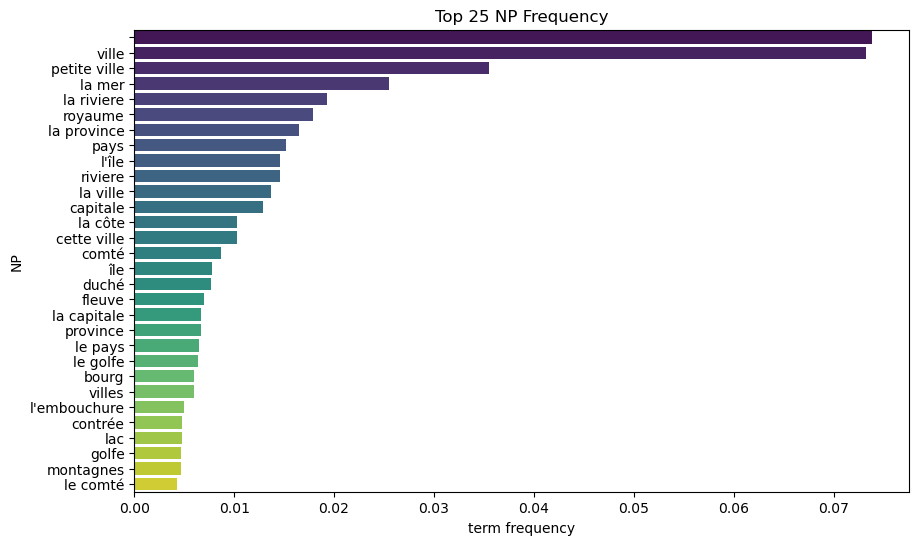

In [188]:

plt.figure(figsize=(10, 6))
sns.barplot(x='TF', y='Word', data=df, palette='viridis')
plt.title('Top 25 NP Frequency')
plt.xlabel('term frequency')
plt.ylabel('NP')
plt.show()



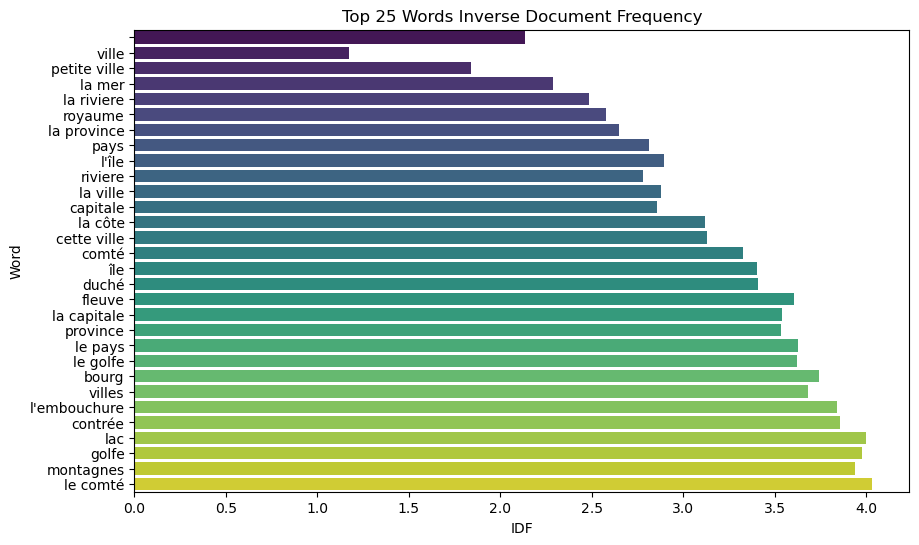

In [189]:
plt.figure(figsize=(10, 6))
sns.barplot(x='IDF', y='Word', data=df, palette='viridis')
plt.title('Top 25 Words Inverse Document Frequency')
plt.xlabel('IDF')
plt.ylabel('Word')
plt.show()

# spacy doc original code

In [190]:
#get the doc from jsonl that has  'volume': 6, 'article': 244
def get_doc_from_jsonl(volume, article):
    for index,doc in enumerate(jsonl):
        if doc['volume'] == volume and doc['article'] == article:
            return doc, docs[index]
    return None

etoile, doc = get_doc_from_jsonl(13,1416)

In [191]:
doc.to_json()


{'text': 'PRIEST, Saint, (Géog. mod.) en latin du moyen âge, Castrum sancti praejecti ; petite ville, ou plûtôt bourg de France dans le Forez, au diocèse de Lyon, avec le titre de baronnie. (D. J.)',
 'tokens': [{'id': 0, 'start': 0, 'end': 6},
  {'id': 1, 'start': 6, 'end': 7},
  {'id': 2, 'start': 8, 'end': 13},
  {'id': 3, 'start': 13, 'end': 14},
  {'id': 4, 'start': 15, 'end': 16},
  {'id': 5, 'start': 16, 'end': 20},
  {'id': 6, 'start': 20, 'end': 21},
  {'id': 7, 'start': 22, 'end': 25},
  {'id': 8, 'start': 25, 'end': 26},
  {'id': 9, 'start': 26, 'end': 27},
  {'id': 10, 'start': 28, 'end': 30},
  {'id': 11, 'start': 31, 'end': 36},
  {'id': 12, 'start': 37, 'end': 39},
  {'id': 13, 'start': 40, 'end': 45},
  {'id': 14, 'start': 46, 'end': 49},
  {'id': 15, 'start': 49, 'end': 50},
  {'id': 16, 'start': 51, 'end': 58},
  {'id': 17, 'start': 59, 'end': 65},
  {'id': 18, 'start': 66, 'end': 75},
  {'id': 19, 'start': 76, 'end': 77},
  {'id': 20, 'start': 78, 'end': 84},
  {'id'

In [192]:
def print_json_architecture(json_data, indent=0):
    for key, value in json_data.items():
        print(" '-- " * indent + key)  # Print the key with appropriate indentation
        if isinstance(value, dict):
            print_json_architecture(value, indent + 1)  # Recursively call the function for nested dictionaries
        if isinstance(value, list):
            print_json_architecture(value[0], indent + 1)  # Recursively call the function for nested dictionaries

print_json_architecture(etoile)

work
volume
article
paragraph
headword
authors
domains
text
tokens
 '-- id
 '-- start
 '-- end
spans
 '-- sc
 '--  '-- start
 '--  '-- end
 '--  '-- label
 '--  '-- kb_id


In [193]:
options = {'colors': {'NP-Spatial': '#27AE60', 'NC-Spatial': '#85C1E9','ENE-Spatial': '#196F3D', 'Relation': '#F5B041'}}
spacy.displacy.render(doc, style='span', options=options, jupyter=True)

In [194]:
# print textspan + label
for span in etoile["spans"]['sc']:
    print(etoile["text"][span["start"]:span["end"]], span["label"])

bourg NC-Spatial
France NP-Spatial
dans Relation
au Relation
diocèse NC-Spatial
Lyon NP-Spatial
petite ville NC-Spatial
le Forez NP-Spatial
bourg de France ENE-Spatial
diocèse de Lyon ENE-Spatial
Géog. mod. Domain-mark
bourg de France dans le Forez ENE-Spatial
petite ville, ou plûtôt bourg de France dans le Forez ENE-Spatial
petite ville, ou plûtôt bourg de France dans le Forez, au diocèse de Lyon ENE-Spatial
